In [13]:
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
import os
from matplotlib import pyplot as plt

# Path to the dataset and segmentation results
path_to_data = '../../proj_try/dataset2/1/face_crop/'
path_to_segmented_op = '../../proj_try/dataset2/1/face_crop_segmentation/'
image_names = os.listdir(path_to_data)
image_names = sorted(image_names)
ans_names = os.listdir(path_to_segmented_op)
ans_names = sorted(ans_names)

def segment_image_using_canny(img_name, ans_name, show=False, save=True, low_threshold=100, high_threshold=200):
    # Takes in one image and returns the segmented output i.e. seg and also returns the Jaccard score
    img = cv2.imread(path_to_data + img_name)
    seg = cv2.imread(path_to_segmented_op + ans_name)
    
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    canny_edges = cv2.Canny(gray_img, low_threshold, high_threshold)
    
    # Process the segmentation mask (converting to binary)
    seg = seg.reshape(-1, 3)
    seg2 = np.zeros((seg.shape[0]))
    
    # Convert the segmented mask to binary (1 for mask, 0 for non-mask)
    for i in range(seg.shape[0]):
        val = seg[i][0]
        if abs(255 - val) < abs(val - 0):
            val = 1  # Mask area
        else:
            val = 0  # Non-mask area
        seg2[i] = val

    seg = seg2
    
    # Convert Canny edge results to binary format (1 for edge, 0 for non-edge)
    canny_edges_bin = np.zeros_like(canny_edges)
    canny_edges_bin[canny_edges == 255] = 1
    
    # Calculate Jaccard score (intersection over union) for both possible labelings
    s1 = jaccard_score(y_true=seg.flatten(), y_pred=canny_edges_bin.flatten())
    s2 = jaccard_score(y_true=seg.flatten(), y_pred=1 - canny_edges_bin.flatten())
    
    # Choose the best Jaccard score
    score = max(s1, s2)
    print('score is ', score)
    
    # If necessary, flip the labels to match the mask region
    if s1 < s2:
        canny_edges_bin = 1 - canny_edges_bin
    
    # Show the results if required
    if show:
        plt.title('Canny Edge Detected Segmentation for ' + img_name)
        plt.axis('off')
        plt.imshow(canny_edges_bin, cmap='gray')
        plt.show()
        plt.close()

        plt.title('Ground Truth result for ' + ans_name)
        plt.axis('off')
        plt.imshow(seg.reshape(img.shape[:2]), cmap='gray')
        plt.show()
        plt.close()

    # Save the results to a file if required
    if save:
        plt.title('Canny Edge Detected Segmentation for ' + img_name)
        plt.axis('off')
        plt.imshow(canny_edges_bin, cmap='gray')
        plt.savefig(f'./output/canny/{img_name}')
        plt.close()

    return (seg.reshape(img.shape[:2]), score)

# Calculate average Jaccard score over a set of images
tot = 0
count = 5  # You can adjust the number of images to process
for i in range(0, count):
    seg_pred, score = segment_image_using_canny(image_names[i], ans_names[i], show=False, save=False)
    print(f"Jaccard Score for {image_names[i]}: {score}")
    tot += score

print('Average Jaccard score:', tot / count)



score is  0.6095388713167971
Jaccard Score for 000000_1.jpg: 0.6095388713167971
score is  0.3134512546277252
Jaccard Score for 000001_1.jpg: 0.3134512546277252
score is  0.3404255319148936
Jaccard Score for 000002_1.jpg: 0.3404255319148936
score is  0.41373686417315686
Jaccard Score for 000003_1.jpg: 0.41373686417315686
score is  0.17262423714036618
Jaccard Score for 000004_1.jpg: 0.17262423714036618
Average Jaccard score: 0.36995535183458783


In [175]:
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
import os
from matplotlib import pyplot as plt
import random
from PIL import ImageEnhance

# Path to the dataset and segmentation results
path_to_data = '../../proj_try/dataset2/1/face_crop/'
path_to_segmented_op = '../../proj_try/dataset2/1/face_crop_segmentation/'
image_names = os.listdir(path_to_data)
image_names = sorted(image_names)
ans_names = os.listdir(path_to_segmented_op)
ans_names = sorted(ans_names)


def merge_contours(contours, min_distance=30):
    """
    Merges contours that are within a certain distance.
    """
    # Calculate centroids of all contours
    centroids = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        centroids.append((cX, cY))
    
    # Merge contours based on proximity of centroids
    merged_contours = []
    visited = [False] * len(contours)
    
    for i in range(len(contours)):
        if visited[i]:
            continue
        
        merged_cnt = contours[i]
        visited[i] = True
        
        for j in range(i + 1, len(contours)):
            if visited[j]:
                continue
            
            # Calculate distance between centroids
            dist = np.linalg.norm(np.array(centroids[i]) - np.array(centroids[j]))
            
            if dist < min_distance:
                # Merge contours if they are close enough
                merged_cnt = np.concatenate((merged_cnt, contours[j]))
                visited[j] = True
        
        merged_contours.append(merged_cnt)
    
    return merged_contours

def segment_image_using_canny(img_name, ans_name, show=False, save=True, low_threshold=100, high_threshold=200):
    img = cv2.imread(path_to_data + img_name)
    seg = cv2.imread(path_to_segmented_op + ans_name)
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.blur(gray_img, (3,3))
    edges = cv2.Canny(gray_img, low_threshold, high_threshold)

    # x = cv2.dilate(edges, None)
    


    cnt, ret = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cnt = [cv2.approxPolyDP(x, 3, True) for x in cnt]
    # cnt = [x for x in cnt if cv2.contourArea(x) > 50]
    # cnt = merge_contours(cnt, min_distance=1000)
    empty_image = np.zeros_like(gray_img)
    cv2.drawContours(empty_image, cnt, -1, (255, 255, 255), 2)
    row_consider = []
    col_consider = []
    s1 = 0.05
    s2 = 0.05
    for i in range(empty_image.shape[0]//6, empty_image.shape[0], 4):
        start = -1
        end = -1
        count = 0
        for j in range(empty_image.shape[1]):
            if i+4 <= empty_image.shape[0] and (empty_image[i][j] > 0 or empty_image[i+1][j] > 0 or empty_image[i+2][j]> 0 or empty_image[i+3][j] > 0):
                count += 1
            
        
        if count > empty_image.shape[0]/6:
            row_consider.append(i)
    if len(row_consider) == 0:
        row_consider.append(empty_image.shape[0]//2)
        row_consider.append(empty_image.shape[0]-1)
    start_row = np.min(np.array(row_consider))
    end_row = np.max(np.array(row_consider))
 

    # similarly do for column
    for j in range(0, empty_image.shape[1], 4):
        start = -1
        end = -1
        count = 0
        for i in range(empty_image.shape[0]):
            if j+4 <= empty_image.shape[1] and (empty_image[i][j] > 0 or empty_image[i][j+1] > 0 or empty_image[i][j+2]> 0 or empty_image[i][j+3] > 0):
                count += 1
            
        if count > empty_image.shape[0]/3:
            col_consider.append(i)

    if len(col_consider) == 0:
        col_consider.append(empty_image.shape[1])
        col_consider.append(empty_image.shape[1]-1)
    start_col = np.min(np.array(col_consider))
    end_col = np.max(np.array(col_consider))

    # print('start col is', start_col)
    # print('end col is', end_col)
    # print('col consider is', len(col_consider))


    # print('count is ', count)
    # print('rows are', empty_image.shape[0])

    if end_col - start_col < empty_image.shape[1]//2:
        start_col = 20
        end_col = empty_image.shape[1] - 20
    for row in range(start_row, end_row):
        for col in range(start_col, end_col):
            empty_image[row][col] = 255



    if show:
        plt.axis('off')
        plt.title('output')
        plt.imshow(empty_image, cmap='gray')
        plt.show()
        plt.close()
        
        plt.axis('off')
        plt.title('answer')
        plt.imshow(seg, cmap='gray')
        plt.show()
        plt.close()

    empty_image[empty_image > 0] = 1
    seg[seg>0] = 1
    seg = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
    s1 += jaccard_score(empty_image.flatten(), seg.flatten())
    s2 += jaccard_score((1-empty_image).flatten(), seg.flatten())

    score = max(s1, s2)
    return score

tot = 0
count = 500  # You can adjust the number of images to process
for i in range(0, count):
    score = segment_image_using_canny(image_names[i], ans_names[i], show=False, save=False)
    print(f"Jaccard Score for {image_names[i]}: {score}")
    tot += score

print('Average Jaccard score:', tot / count)


    # plt.axis('off')
    # plt.title('dialated')
    # plt.imshow(x)
    # plt.show()
    # plt.close()

Jaccard Score for 000000_1.jpg: 0.7552431825853717
Jaccard Score for 000001_1.jpg: 0.4280671006509765
Jaccard Score for 000002_1.jpg: 0.4376690672756016
Jaccard Score for 000003_1.jpg: 0.6608105504034687
Jaccard Score for 000004_1.jpg: 0.3528692879914984
Jaccard Score for 000005_1.jpg: 0.5341303427845959
Jaccard Score for 000006_1.jpg: 0.5288516746411484
Jaccard Score for 000006_2.jpg: 0.5182680901542112
Jaccard Score for 000007_1.jpg: 0.5331621686171484
Jaccard Score for 000007_2.jpg: 0.40240572171651495
Jaccard Score for 000008_1.jpg: 0.38638056543084476
Jaccard Score for 000009_1.jpg: 0.6993055555555556
Jaccard Score for 000010_1.jpg: 0.5271307173206699
Jaccard Score for 000011_1.jpg: 0.44042821158690176
Jaccard Score for 000011_2.jpg: 0.558235294117647
Jaccard Score for 000011_3.jpg: 0.36775700934579436
Jaccard Score for 000011_4.jpg: 0.46025641025641023
Jaccard Score for 000011_5.jpg: 0.35156472261735416
Jaccard Score for 000011_6.jpg: 0.5048104956268221
Jaccard Score for 000012_1

(405, 388) (405, 388)


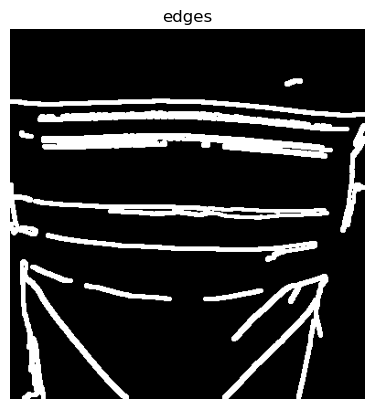

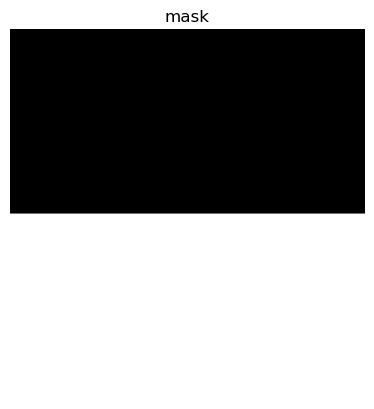

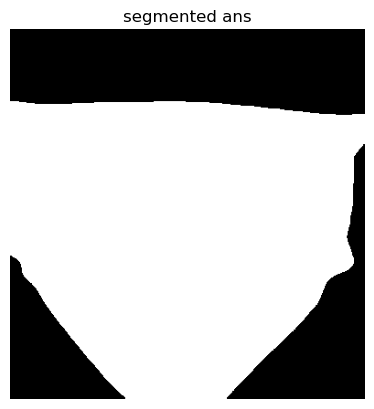

Jaccard Score for 000000_1.jpg: 0.45409363105195527
Average Jaccard score: 0.45409363105195527


In [153]:
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
import os
from matplotlib import pyplot as plt
import random
from PIL import ImageEnhance
from collections import deque

# Path to the dataset and segmentation results
path_to_data = '../../proj_try/dataset2/1/face_crop/'
path_to_segmented_op = '../../proj_try/dataset2/1/face_crop_segmentation/'
image_names = os.listdir(path_to_data)
image_names = sorted(image_names)
ans_names = os.listdir(path_to_segmented_op)
ans_names = sorted(ans_names)


def merge_contours(contours, min_distance=30):
    """
    Merges contours that are within a certain distance.
    """
    # Calculate centroids of all contours
    centroids = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        centroids.append((cX, cY))
    
    # Merge contours based on proximity of centroids
    merged_contours = []
    visited = [False] * len(contours)
    
    for i in range(len(contours)):
        if visited[i]:
            continue
        
        merged_cnt = contours[i]
        visited[i] = True
        
        for j in range(i + 1, len(contours)):
            if visited[j]:
                continue
            
            # Calculate distance between centroids
            dist = np.linalg.norm(np.array(centroids[i]) - np.array(centroids[j]))
            
            if dist < min_distance:
                # Merge contours if they are close enough
                merged_cnt = np.concatenate((merged_cnt, contours[j]))
                visited[j] = True
        
        merged_contours.append(merged_cnt)
    
    return merged_contours

def bfs(edges, start_x, start_y, visited):
        """
        Perform BFS from the starting pixel (start_x, start_y) and return the list of connected pixels.
        """
        # Directions for 4-connected neighbors (Up, Down, Left, Right)
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        # Queue for BFS
        queue = deque([(start_x, start_y)])
        connected_pixels = []
        
        # Mark the start pixel as visited
        visited[start_x, start_y] = True
        
        while queue:
            x, y = queue.popleft()
            connected_pixels.append((x, y))
            
            # Explore all 4-connected neighbors
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < edges.shape[0] and 0 <= ny < edges.shape[1] and not visited[nx, ny] and edges[nx, ny] == 255:
                    visited[nx, ny] = True
                    queue.append((nx, ny))
        
        return connected_pixels

def segment_image_using_canny(img_name, ans_name, show=False, save=True, low_threshold=100, high_threshold=200):
    img = cv2.imread(path_to_data + img_name)
    seg = cv2.imread(path_to_segmented_op + ans_name)
    seg = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.blur(gray_img, (3,3))
    edges = cv2.Canny(gray_img, low_threshold, high_threshold)
    edges = cv2.dilate(edges, None)
    
    # print('unique edges are', np.unique(edges)) # 0 and 255

    cnt, ret = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cnt = [cv2.approxPolyDP(x, 3, True) for x in cnt]
    # cnt = [x for x in cnt if cv2.contourArea(x) > 50]
    # cnt = merge_contours(cnt, min_distance=1000)
    mask = np.zeros_like(edges, dtype=np.uint8)
    cv2.drawContours(edges, cnt, -1, (255, 255, 255), 2)

    visited = np.zeros_like(edges, dtype=bool)
    # we will run a bfs to find large enough connected components
    # each large enough connected component will be stored in terms of it's xmin, xmax, ymin, ymax
    # how do we determine large enough?
    # trial and error
    min_size = mask.shape[0]//6
    minnx=10000
    maxxx = 0
    minny=10000
    maxxy=0
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            # Start BFS from every unvisited white pixel in the edge image
            if edges[i, j] == 255 and not visited[i, j]:
                connected_pixels = bfs(edges, i, j, visited)
                
                # If the component size is large enough, process it
                if len(connected_pixels) >= min_size:
                    # Get the bounding box of the connected component
                    minx = min(connected_pixels, key=lambda p: p[0])[0]
                    maxx = max(connected_pixels, key=lambda p: p[0])[0]
                    miny = min(connected_pixels, key=lambda p: p[1])[1]
                    maxy = max(connected_pixels, key=lambda p: p[1])[1]
                    
                    minnx = min(minnx, minx)
                    maxxx = max(maxxx, maxx)
                    minny = min(minny, miny)
                    maxxy = max(maxxy, maxy)
                    # Store the bounding box
                    
                    minnx = max(minnx, seg.shape[0]//2)
                    # minny = max(minny, seg.shape[1]//2)
                    # Fill the mask with white inside the bounding box
                    mask[minnx:maxxx+1, minny:maxxy+1] = 255
    print(seg.shape, mask.shape)
    for i in range(seg.shape[0]):
        for j in range(seg.shape[1]):
            val = seg[i][j]
            if abs(255-val) > abs(val-0):
                val = 0
            else:
                val = 255
            seg[i][j] = val

    seg[seg == 255] = 1
    mask[mask == 255] = 1
    score = jaccard_score(y_true=seg.flatten(), y_pred=mask.flatten())
    if show:
        plt.axis('off')
        plt.title('edges')
        plt.imshow(edges, cmap='gray')
        plt.show()
        plt.close()

        plt.axis('off')
        plt.title('mask')
        plt.imshow(mask, cmap='gray')
        plt.show()
        plt.close()

        plt.axis('off')
        plt.title('segmented ans')
        plt.imshow(seg, cmap='gray')
        plt.show()
        plt.close()
    # we now have mask, bounding_boxes
    return mask, bounding_boxes, score    




    
tot = 0
count = 1  # You can adjust the number of images to process
for i in range(0, count):
    mask, bounding_boxes, score = segment_image_using_canny(image_names[i], ans_names[i], show=True, save=False)
    
    print(f"Jaccard Score for {image_names[i]}: {score}")
    tot += score

print('Average Jaccard score:', tot / count)


    